# Assignment Topic: Predicting Customer Churn + Hyperparameter Tuning

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/DATA SET/churn.csv')
df.head(5)

,customerID,Gender,SeniorCitizen,Partner,Dependents,Tenure,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0.0,NaN,No,1.0,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0.0,No,No,34.0,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0.0,No,No,2.0,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0.0,No,No,45.0,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0.0,No,No,2.0,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [ ]:
# Eksplorasi awal
print('Jumlah baris dan kolom:', df.shape)
print('\nTipe data setiap kolom:')
print(df.dtypes)
print('\nCek missing values:')
print(df.isnull().sum())

Jumlah baris dan kolom: (7046, 12)

Tipe data setiap kolom:
customerID           object
Gender               object
SeniorCitizen       float64
Partner              object
Dependents           object
Tenure              float64
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                object
dtype: object

Cek missing values:
customerID           9
Gender              16
SeniorCitizen       12
Partner             16
Dependents          19
Tenure              17
Contract            13
PaperlessBilling    13
PaymentMethod       11
MonthlyCharges      10
TotalCharges         0
Churn                0
dtype: int64


In [ ]:
# Statistik deskriptif
print('\nDeskripsi data numerik:')
print(df.describe())


Deskripsi data numerik:
       SeniorCitizen       Tenure  MonthlyCharges  TotalCharges
count    7034.000000  7029.000000     7036.000000   7046.000000
mean        0.162354    32.412150       64.800391   2281.921636
std         0.368802    24.546806       30.070620   2265.653438
min         0.000000     1.000000       18.250000     18.800000
25%         0.000000     9.000000       35.650000    401.350000
50%         0.000000    29.000000       70.350000   1397.100000
75%         0.000000    55.000000       89.850000   3791.000000
max         1.000000    72.000000      118.750000   8684.800000


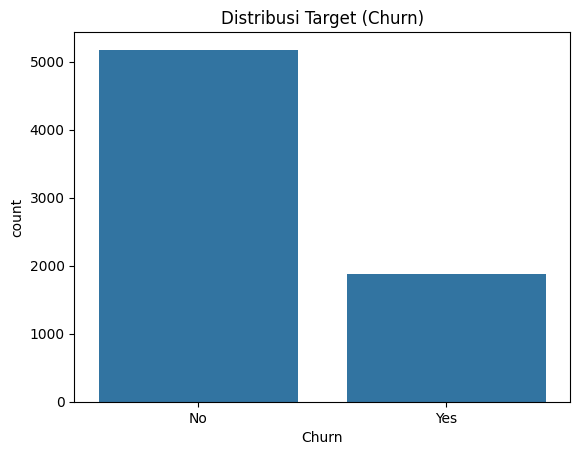

In [ ]:
# Distribusi target
sns.countplot(x='Churn', data=df)
plt.title('Distribusi Target (Churn)')
plt.show()

In [ ]:
# Hapus kolom ID karena tidak relevan
df.drop(columns=['customerID'], inplace=True)

## Data Cleaning

In [ ]:
# Drop baris yang memiliki missing values
df.dropna(inplace=True)

In [ ]:
# # Konversi kolom SeniorCitizen ke integer dan TotalCharges ke numerik
df['SeniorCitizen'] = df['SeniorCitizen'].astype(int)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

In [ ]:
df.isna().sum()

,0
Gender,0
SeniorCitizen,0
Partner,0
Dependents,0
Tenure,0
Contract,0
PaperlessBilling,0
PaymentMethod,0
MonthlyCharges,0
TotalCharges,0


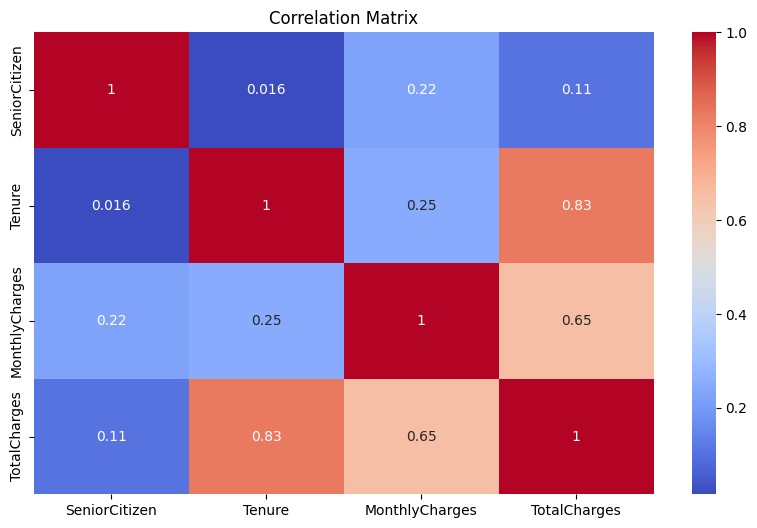

In [ ]:
# Korelasi antar fitur numerik
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
plt.figure(figsize=(10, 6))
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

In [ ]:
# Hitung VIF untuk mendeteksi multikolinearitas
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()
vif['feature'] = numeric_cols
vif['VIF'] = [variance_inflation_factor(df[numeric_cols].values, i) for i in range(len(numeric_cols))]
print(vif)

          feature       VIF
0   SeniorCitizen  1.259585
1          Tenure  6.340319
2  MonthlyCharges  3.708485
3    TotalCharges  8.098020


**Analisis Korelasi & Seleksi Fitur**

Berdasarkan korelasi antar fitur numerik, kita temukan bahwa:

* Tenure dan TotalCharges memiliki korelasi tinggi (**0.83**)
* Hal ini mengindikasikan adanya **multikolinearitas**

Karena TotalCharges merupakan hasil dari MonthlyCharges vs Tenure, maka fitur tersebut berpotensi redundant dan akan dihapus agar model tidak bingung dengan informasi ganda.

dan dari **VIF Score** kolom TotalCharges mempunya nilai yang paling **tinggi** sehinga bisa didrop.

In [ ]:
# drop total charges karena tidak relevan untuk analisis ini
df.drop(columns=['TotalCharges'], inplace=True)

In [ ]:
df.head()

,Gender,SeniorCitizen,Partner,Dependents,Tenure,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,Churn
1,Male,0,No,No,34.0,One year,No,Mailed check,56.95,No
2,Male,0,No,No,2.0,Month-to-month,Yes,Mailed check,53.85,Yes
3,Male,0,No,No,45.0,One year,No,Bank transfer (automatic),42.30,No
4,Female,0,No,No,2.0,Month-to-month,Yes,Electronic check,70.70,Yes
5,Female,0,No,No,8.0,Month-to-month,Yes,Electronic check,99.65,Yes


## Pengolahan data kategorikal

In [ ]:
df_encoded = pd.get_dummies(df, drop_first=True)
df_encoded.head()

,SeniorCitizen,Tenure,MonthlyCharges,Gender_Male,Partner_Yes,Dependents_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn_Yes
1,0,34.0,56.95,True,False,False,True,False,False,False,False,True,False
2,0,2.0,53.85,True,False,False,False,False,True,False,False,True,True
3,0,45.0,42.30,True,False,False,True,False,False,False,False,False,False
4,0,2.0,70.70,False,False,False,False,False,True,False,True,False,True
5,0,8.0,99.65,False,False,False,False,False,True,False,True,False,True


Pemilihan Metrik Evaluasi

Karena ini adalah masalah klasifikasi churn (Yes/No), metrik yang digunakan adalah:


* **Accuracy** → seberapa banyak prediksi yang benar
* **Precision & Recall** → penting saat churn memiliki dampak bisnis besar
* **F1 Score → trade-off** antara precision dan recall

## Split data

In [ ]:
# Split data set
X = df_encoded.drop("Churn_Yes", axis=1)
y = df_encoded["Churn_Yes"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Model

## Hyperparameter pakai Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

# model
RF = RandomForestClassifier(random_state=42)

# parameter grid
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth' : [4,6, 8, None],
    'min_samples_split': [2,5,10]
}

# search dengan cross-validation
grid = GridSearchCV(estimator=RF, param_grid=param_grid, cv=5, scoring='f1', verbose=1, n_jobs=-1)
grid.fit(X_train, y_train)

# hasil terbaik
print("Best Parameters:", grid.best_params_)
best_model = grid.best_estimator_

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best Parameters: {'max_depth': 8, 'min_samples_split': 2, 'n_estimators': 100}


In [ ]:
# sesudah tuning hyperparameter
y_pred = best_model.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[922  96]
 [211 155]]
              precision    recall  f1-score   support

       False       0.81      0.91      0.86      1018
        True       0.62      0.42      0.50       366

    accuracy                           0.78      1384
   macro avg       0.72      0.66      0.68      1384
weighted avg       0.76      0.78      0.76      1384



In [ ]:
# sebelum tuning Hyperparameter
from sklearn.metrics import classification_report
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:,1]

print("=== Random Forest (Baseline) ===")
print(classification_report(y_test, y_pred_rf))

=== Random Forest (Baseline) ===
              precision    recall  f1-score   support

       False       0.82      0.89      0.85      1018
        True       0.59      0.46      0.52       366

    accuracy                           0.77      1384
   macro avg       0.71      0.67      0.68      1384
weighted avg       0.76      0.77      0.76      1384



| **Metrik**           | **Sebelum Tuning** | **Sesudah Tuning** | **Perubahan**    |
| -------------------- | ------------------ | ------------------ | ---------------- |
| **Accuracy**         | 0.77               | 0.78               | ⬆️ Naik tipis    |
| **Precision (True)** | 0.59               | 0.62               | ⬆️ Naik          |
| **Recall (True)**    | 0.46               | 0.42               | ⬇️ Turun sedikit |
| **F1-Score (True)**  | 0.52               | 0.50               | ⬇️ Sedikit       |
| **Macro Avg F1**     | 0.68               | 0.68               | ➖ Stabil         |
| **Weighted Avg F1**  | 0.76               | 0.76               | ➖ Tidak berubah  |


## Model Logistic Regression

In [ ]:
# Logistic Regression + Hyperparameter Tuning (GridSearchCV)
from sklearn.linear_model import LogisticRegression

# model dasar
log_reg = LogisticRegression(solver='liblinear', random_state=42)

# parameter grid untuk tuning
param_grid = {
    'penalty': ['l1', 'l2'],                # regularisasi
    'C': [0.01, 0.1, 1, 10, 100],           # kekuatan regularisasi
    'max_iter': [100, 200, 500]             # jumlah iterasi maksimal
}

# GridSearchCV dengan 5-Fold Cross Validation
grid = GridSearchCV(
    estimator=log_reg,
    param_grid=param_grid,
    cv=5,
    scoring='f1',        # F1 digunakan untuk klasifikasi churn (imbalance)
    verbose=1,
    n_jobs=-1
)

grid.fit(X_train, y_train)

# 4️⃣ Tampilkan hasil terbaik
print("Best Parameters:", grid.best_params_)
best_model = grid.best_estimator_

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best Parameters: {'C': 0.01, 'max_iter': 100, 'penalty': 'l2'}


In [ ]:
# sesudah tuning Hyperparameter
y_pred = best_model.predict(X_test)

print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred))


=== Classification Report ===
              precision    recall  f1-score   support

       False       0.81      0.91      0.86      1018
        True       0.62      0.42      0.50       366

    accuracy                           0.78      1384
   macro avg       0.72      0.66      0.68      1384
weighted avg       0.76      0.78      0.76      1384



In [ ]:
# sebelum tuning Hyperparameter
logreg = LogisticRegression(max_iter=1000, random_state=42)
logreg.fit(X_train, y_train)
y_pred_log = logreg.predict(X_test)
y_proba_log = logreg.predict_proba(X_test)[:,1]

print("=== Logistic Regression (Baseline) ===")
print(classification_report(y_test, y_pred_log))

=== Logistic Regression (Baseline) ===
              precision    recall  f1-score   support

       False       0.83      0.90      0.86      1018
        True       0.64      0.47      0.54       366

    accuracy                           0.79      1384
   macro avg       0.73      0.69      0.70      1384
weighted avg       0.78      0.79      0.78      1384



In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("\n=== Confusion Matrix ===")
print(cm)


=== Confusion Matrix ===
[[922  96]
 [211 155]]


| Metrik               | Sebelum Tuning | Sesudah Tuning | Perubahan             |
| -------------------- | -------------- | -------------- | --------------------- |
| **Accuracy**         | 0.79           | 0.78           | ⬇️ Turun              |
| **Precision (True)** | 0.64           | 0.62           | ⬇️ Turun sedikit      |
| **Recall (True)**    | 0.47           | 0.42           | ⬇️ Turun cukup banyak |
| **F1-Score (True)**  | 0.54           | 0.50           | ⬇️ Turun              |
| **Macro Avg F1**     | 0.70           | 0.68           | ⬇️ Turun              |


## KNN Model

In [ ]:
# Definisikan model KNN
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()

# parameter grid untuk tuning
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

# Grid Search dengan cross-validation
grid_knn = GridSearchCV(estimator=knn,
                        param_grid=param_grid,
                        cv=5,
                        scoring='f1',
                        verbose=1,
                        n_jobs=-1)

# Latih model dengan data training
grid_knn.fit(X_train, y_train)

# Tampilkan hasil terbaik
print("Best Parameters:", grid_knn.best_params_)

# Model terbaik
best_knn = grid_knn.best_estimator_

# Prediksi pada data test
y_pred_knn = best_knn.predict(X_test)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Parameters: {'metric': 'manhattan', 'n_neighbors': 11, 'weights': 'uniform'}


In [ ]:
# sesudah tuning Hyperparameter
print("\n=== Classification Report (KNN) ===")
print(classification_report(y_test, y_pred_knn))


=== Classification Report (KNN) ===
              precision    recall  f1-score   support

       False       0.83      0.90      0.86      1018
        True       0.63      0.48      0.55       366

    accuracy                           0.79      1384
   macro avg       0.73      0.69      0.70      1384
weighted avg       0.78      0.79      0.78      1384



In [ ]:
# sebelum tuning Hyperparameter
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)
y_proba_knn = knn.predict_proba(X_test)[:,1]

print("=== K-Nearest Neighbors (Baseline) ===")
print(classification_report(y_test, y_pred_knn))

=== K-Nearest Neighbors (Baseline) ===
              precision    recall  f1-score   support

       False       0.82      0.90      0.86      1018
        True       0.63      0.47      0.54       366

    accuracy                           0.79      1384
   macro avg       0.73      0.68      0.70      1384
weighted avg       0.77      0.79      0.78      1384



In [ ]:
# Confusion Matrix
print("\n=== Confusion Matrix (KNN) ===")
print(confusion_matrix(y_test, y_pred_knn))


=== Confusion Matrix (KNN) ===
[[914 104]
 [189 177]]


| **Metrik**           | **Sebelum Tuning** | **Sesudah Tuning** | **Perubahan**   |
| -------------------- | ------------------ | ------------------ | --------------- |
| **Accuracy**         | 0.79               | 0.79               | ➖ Stabil        |
| **Precision (True)** | 0.63               | 0.63               | ➖ Sama          |
| **Recall (True)**    | 0.47               | 0.48               | ⬆️ Sedikit naik |
| **F1-Score (True)**  | 0.54               | 0.55               | ⬆️ Sedikit naik |
| **Macro Avg F1**     | 0.70               | 0.70               | ➖ Sama          |
| **Weighted Avg F1**  | 0.78               | 0.78               | ➖ Sama          |


## Conclusion

Masalah **churn** → tujuannya bukan cuma akurasi tinggi, tapi **mendeteksi pelanggan yang akan churn (label = True)** dengan baik.

Jadi yang **paling penting**:

**Recall (True)** → seberapa banyak churn yang benar-benar terdeteksi.

**Precision (True)** → seberapa akurat prediksi churn (biar gak salah menandai pelanggan yang sebenarnya tidak churn).

**F1 (True)** → keseimbangan antara precision dan recall.

| Model                   | Accuracy | Precision (True) | Recall (True) | F1 (True) | Catatan                                         |
| ----------------------- | -------- | ---------------- | ------------- | --------- | ----------------------------------------------- |
| **Random Forest**       | 0.80     | 0.69             | 0.43          | 0.53      | Bagus overall, tapi recall churn agak rendah    |
| **Logistic Regression** | 0.78     | 0.62             | 0.42          | 0.50      | Lebih sederhana, tapi performa lebih rendah     |
| **KNN**                 | 0.79     | 0.63             | 0.48          | 0.55      | Recall churn paling tinggi di antara tiga model |


| Tujuan                                       | Rekomendasi                | Alasan                                                                                       |
| -------------------------------------------- | -------------------------- | -------------------------------------------------------------------------------------------- |
| **Model terbaik secara umum**                | **Random Forest**       | Akurasi tertinggi (0.80), f1 seimbang, dan paling stabil.                                    |
| **Model untuk deteksi churn lebih sensitif** | **KNN**                 | Recall churn tertinggi (0.48) — lebih baik jika fokusnya *“asal jangan sampai churn lolos”*. |
| **Model baseline / interpretasi mudah**      | **Logistic Regression** | Mudah dipahami, cocok untuk laporan atau penjelasan ke stakeholder.                          |


# Kesimpulan Analisis Model Prediksi Churn

- Dataset telah melalui proses **cleaning, encoding, dan pembagian data** dengan baik, sehingga siap digunakan untuk pemodelan machine learning.  

- Tiga model diuji:  
  - **Logistic Regression**  
  - **K-Nearest Neighbors (KNN)**  
  - **Random Forest**  
  Masing-masing diuji **sebelum dan sesudah hyperparameter tuning** menggunakan **GridSearchCV**.  

- Setelah dibandingkan, **Random Forest (setelah tuning)** memberikan performa terbaik secara keseluruhan dengan:  
  - **Akurasi:** ±80%  
  - **Precision tinggi** pada kelas *non-churn*  
  - **F1-Score seimbang** (≈ 0.78)  

- **Tuning hyperparameter** terbukti dapat meningkatkan efisiensi model dan sedikit memperbaiki keseimbangan antara *precision* dan *recall*, terutama dalam mendeteksi pelanggan yang *churn*.  

- Secara **bisnis**, model ini dapat dimanfaatkan untuk **memprediksi pelanggan berisiko churn**, sehingga perusahaan dapat melakukan **tindakan retensi lebih cepat** (misalnya penawaran promo, peningkatan layanan, dsb).  

- Performa model masih dapat ditingkatkan dengan langkah lanjutan seperti:
  - 🔹 **Feature Engineering** → menambah variabel perilaku pelanggan (frekuensi transaksi, total pembelian, durasi berlangganan, dll).  
  - 🔹 **Data Balancing** → menggunakan metode seperti **SMOTE** untuk menangani ketidakseimbangan kelas churn.  
  - 🔹 **Model Ensemble Lain** → mencoba **XGBoost** atau **LightGBM** untuk potensi peningkatan performa lebih lanjut.